# Proyecto Final - Accidentes en USA

En este proyecto se va a utilizar un DataSet de accidentes en US y se va a buscar analizar la gravedad de los mismos, para eso primero vamos a limpiar los datos para poder analizarlos y los vamos a guardar en un indice de Elastic Search y por ultimo vamos a graficar los resultados

Debido a que el dataset es demasiado pesado no se va a subir al repositorio de git pero lo pueden descargar de este link:
[Dataset](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_March23.csv)

## Importar librerías a utilizar

In [2]:
from ElasticSearchProvider import ElasticSearchProvider
import json
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import Hot
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Limpiar datos

### Rutas de archivos

Debido a que vamos a acceder continuamente a varios archivos vamos a guardar las rutas de los mismos en variables

In [3]:
json_file_path = "Datos.json"
csv_file_path = "US_Accidents_March23.csv"
RESPONSE_LITERAL = "response: "

### Datos RAW

este es un ejemplo de los datos antes hacerles modificaciones, según el catalogo que esta en linea ([link](https://smoosavi.org/datasets/us_accidents)) vamos a analizar los datos y pasarlos a algo mas legible

**RAW:**
```CSV
ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,,,0.01,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,,91.0,29.68,10.0,Calm,,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.92805900000001,-82.831184,,,0.01,Accident on Brice Rd at Tussing Rd. Expect delays.,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,,100.0,29.65,10.0,Calm,,0.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,,,0.01,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.20558199999998,,,0.01,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,,,0.01,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590000000004,-82.92519399999998,,,0.01,Accident on I-270 Outerbelt Northbound near Exit 29 OH-3 State St. Expect delays.,Westerville Rd,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
```

>Como se puede observar es complicado leer los datos en ese formato entonces vamos a limpiar y modificar los datos

### Cargar los datos en un csv

Lo primero que vamos a hacer es cargar los datos en data frame y ahi vamos a eliminar algunos datos que consideremos innecesarios y vamos a guardar en un json aleatoriamente 1´000,000 de registros para el análisis

In [3]:
# cargamos los datos desde el csv
df = pd.read_csv(csv_file_path)

# vamos a eliminar las columnas que no nos interesan
df = df.drop(columns=["Airport_Code"])

# vamos a guardar 1000000 de registros aleatorios en el json
df = df.sample(1000000, random_state=1)

df.to_json(json_file_path, orient="records", lines=True)

### Redondear la distancia

In [4]:
# Redondear el campo "Distance(mi)" a 4 dígitos decimales
df = pd.read_json(json_file_path, lines=True, orient="records")

df["Distance(mi)"] = df["Distance(mi)"].round(4)

df.to_json(json_file_path, orient="records", lines=True)

### Darle formato a las fechas

In [6]:
# Convertir los campos a formato datetime y eliminar los ceros adicionales
df = pd.read_json(json_file_path, lines=True, orient="records")

# Convertir las fechas al formato deseado sin los ceros adicionales
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce").dt.strftime("%Y-%m-%d %H:%M:%S")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce").dt.strftime("%Y-%m-%d %H:%M:%S")

# Guardar los datos nuevamente en el archivo JSON
df.to_json(json_file_path, orient="records", lines=True)

### Formatear los datos para evitar errores

**Nota:** Cada que carguemos los datos se nos va a generar otra muestra de datos distinta debido a que agarramos una muestra aleatoria.

Como resultado obtenemos un json con un formato similar al siguiente:

```Json
[
  {
    "ID": "A-3843722",
    "Source": "Source1",
    "Severity": 2,
    "Start_Time": "2023-01-27 23:53:28",
    "End_Time": "2023-01-28 01:16:30",
    "Start_Lat": 35.793736,
    "Start_Lng": -78.64394,
    "End_Lat": 35.795108,
    "End_Lng": -78.643711,
    "Distance(mi)": 0.096,
    "Description": "Incident on PIERCE ST near JEFFERSON ST Drive with caution.",
    "Street": " Adams St",
    "City": "Raleigh",
    "County": "Wake",
    "State": "NC",
    "Zipcode": "27605-1201",
    "Country": "US",
    "Timezone": "US/Eastern",
    "Weather_Timestamp": "2023-01-27 23:51:00",
    "Temperature(F)": 35.0,
    "Wind_Chill(F)": 30.0,
    "Humidity(%)": 59.0,
    "Pressure(in)": 29.86,
    "Visibility(mi)": 10.0,
    "Wind_Direction": "SSW",
    "Wind_Speed(mph)": 6.0,
    "Precipitation(in)": 0.0,
    "Weather_Condition": "Fair",
    "Amenity": false,
    "Bump": false,
    "Crossing": false,
    "Give_Way": false,
    "Junction": false,
    "No_Exit": false,
    "Railway": false,
    "Roundabout": false,
    "Station": false,
    "Stop": false,
    "Traffic_Calming": false,
    "Traffic_Signal": false,
    "Turning_Loop": false,
    "Sunrise_Sunset": "Night",
    "Civil_Twilight": "Night",
    "Nautical_Twilight": "Night",
    "Astronomical_Twilight": "Night"
  },
  {
    "ID": "A-3535146",
    "Source": "Source1",
    "Severity": 3,
    "Start_Time": "2016-11-07 08:04:45",
    "End_Time": "2016-11-07 14:04:45",
    "Start_Lat": 38.76415,
    "Start_Lng": -121.25732,
    "End_Lat": 38.7668,
    "End_Lng": -121.2535,
    "Distance(mi)": 0.275,
    "Description": "At Taylor Rd - Accident.",
    "Street": "I-80 E",
    "City": "Roseville",
    "County": "Placer",
    "State": "CA",
    "Zipcode": "95661",
    "Country": "US",
    "Timezone": "US/Pacific",
    "Weather_Timestamp": "2016-11-07 07:55:00",
    "Temperature(F)": 53.6,
    "Wind_Chill(F)": null,
    "Humidity(%)": 100.0,
    "Pressure(in)": 30.19,
    "Visibility(mi)": 9.0,
    "Wind_Direction": "Calm",
    "Wind_Speed(mph)": null,
    "Precipitation(in)": null,
    "Weather_Condition": "Clear",
    "Amenity": false,
    "Bump": false,
    "Crossing": false,
    "Give_Way": false,
    "Junction": true,
    "No_Exit": false,
    "Railway": false,
    "Roundabout": false,
    "Station": false,
    "Stop": false,
    "Traffic_Calming": false,
    "Traffic_Signal": false,
    "Turning_Loop": false,
    "Sunrise_Sunset": "Day",
    "Civil_Twilight": "Day",
    "Nautical_Twilight": "Day",
    "Astronomical_Twilight": "Day"
  }
]
```
Afortunadamente de donde descargamos el dataset son muy claros por lo que no necesitan de modificaciones mayores entonces ahora vamos a proceder a diseñar el **mapping** para poder subir nuestros datos a **Elastic Search**

### Crear el **Mapping**

En base a los datos diseñamos un **mapping** con el siguiente formato:

```Json
{
  "mappings": {
    "properties": {
      "ID": { "type": "keyword" },
      "Source": { "type": "keyword" },
      "Severity": { "type": "integer" },
      "Start_Time": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss" },
      "End_Time": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss" },
      "Start_Lat": { "type": "float" },
      "Start_Lng": { "type": "float" },
      "End_Lat": { "type": "float" },
      "End_Lng": { "type": "float" },
      "Distance(mi)": { "type": "float" },
      "Description": { "type": "text" },
      "Street": { "type": "keyword" },
      "City": { "type": "keyword" },
      "County": { "type": "keyword" },
      "State": { "type": "keyword" },
      "Zipcode": { "type": "keyword" },
      "Country": { "type": "keyword" },
      "Timezone": { "type": "keyword" },
      "Weather_Timestamp": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss" },
      "Temperature(F)": { "type": "float" },
      "Wind_Chill(F)": { "type": "float", "null_value": -9999 },
      "Humidity(%)": { "type": "float" },
      "Pressure(in)": { "type": "float" },
      "Visibility(mi)": { "type": "float" },
      "Wind_Direction": { "type": "keyword" },
      "Wind_Speed(mph)": { "type": "float", "null_value": -9999 },
      "Precipitation(in)": { "type": "float", "null_value": -9999 },
      "Weather_Condition": { "type": "keyword" },
      "Amenity": { "type": "boolean" },
      "Bump": { "type": "boolean" },
      "Crossing": { "type": "boolean" },
      "Give_Way": { "type": "boolean" },
      "Junction": { "type": "boolean" },
      "No_Exit": { "type": "boolean" },
      "Railway": { "type": "boolean" },
      "Roundabout": { "type": "boolean" },
      "Station": { "type": "boolean" },
      "Stop": { "type": "boolean" },
      "Traffic_Calming": { "type": "boolean" },
      "Traffic_Signal": { "type": "boolean" },
      "Turning_Loop": { "type": "boolean" },
      "Sunrise_Sunset": { "type": "keyword" },
      "Civil_Twilight": { "type": "keyword" },
      "Nautical_Twilight": { "type": "keyword" },
      "Astronomical_Twilight": { "type": "keyword" }
    }
  }
}
```

ahora vamos a proceder a cargar el mapping a Elastic Search pero primero vamos a comprobar la conexión a nuestro servidor de Elastic Search

## Cargar los datos

### Verificar conexión con Elastic Search

In [5]:
try:
        # Create an instance of the ElasticSearchProvider class
        # and establish a connection with the ElasticSearch server
        es_handler = ElasticSearchProvider(index="us-accidents_march23",)
        print("es_handler: ", es_handler, "\n")

        response = es_handler.show_all_indices()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")
        
except Exception as e:
        print(f"An error occurred: {e}")

es_handler:  <ElasticSearchProvider.ElasticSearchProvider object at 0x000001CEDEC1E180> 

response:  {
    ".internal.alerts-transform.health.alerts-default-000001": {
        "aliases": {
            ".alerts-transform.health.alerts-default": {
                "is_write_index": true
            }
        }
    },
    "us-accidents_march23": {
        "aliases": {}
    },
    ".slo-observability.sli-v3.3": {
        "aliases": {}
    },
    "my-index": {
        "aliases": {}
    },
    ".internal.alerts-ml.anomaly-detection.alerts-default-000001": {
        "aliases": {
            ".alerts-ml.anomaly-detection.alerts-default": {
                "is_write_index": true
            }
        }
    },
    ".internal.alerts-observability.slo.alerts-default-000001": {
        "aliases": {
            ".alerts-observability.slo.alerts-default": {
                "is_write_index": true
            }
        }
    },
    ".internal.alerts-default.alerts-default-000001": {
        "aliases": {

c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\Proyecto Final\ElasticSearchProvider.py:268: ElasticsearchWarning: this request accesses system indices: [.apm-custom-link, .kibana_usage_counters_8.17.1_001, .kibana_analytics_8.17.1_001, .kibana_8.17.1_001, .kibana_alerting_cases_8.17.1_001, .kibana_task_manager_8.17.1_001, .apm-agent-configuration, .security-7, .kibana_security_solution_8.17.1_001, .kibana_ingest_8.17.1_001], but in a future major version, direct access to system indices will be prevented by default
  response = self.connection.indices.get_alias(index="*")


>Descripción: Solo comprobamos la conexión con el constructor de la clase de ElasticSearchProvider() y le pasamos el nombre de nuestro indice

Constructor de ElasticSearchProvider:

```Python
def __init__(self, index="person"):
    self.host = "http://localhost:9200"
    #   self.user = str(user)
    #   self.password = str(password)
    self.index = index
    self.index_type = "_doc"
    # Configurar timeout, re-intentos y retry_on_timeout
    self.connection = Elasticsearch(
        self.host,
        timeout=30,  # Tiempo de espera en segundos
        max_retries=3,  # Número máximo de re-intentos
        retry_on_timeout=True  # Re-intentar si hay un timeout
    )
```

Ahora que comprobamos que tenemos conexión con nuestro servidor vamos a cargar el **mapping**

### Cargar el mapping


In [6]:
try:
    with ElasticSearchProvider(index="us-accidents_march23") as es:

        # Cargar el mapping desde el json
        mapping_file_path = "mapping.json"
        mapping_data = pd.read_json(mapping_file_path)
        mapping = mapping_data.to_dict()

        response = es.delete_index()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        response = es.create_index(mapping=mapping)
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        time.sleep(2)

        response = es.get_mapping()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")
        
except Exception as e:
    print(f"an error occurred: {e}")

response:  {
    "acknowledged": true
}

response:  {
    "acknowledged": true,
    "shards_acknowledged": true,
    "index": "us-accidents_march23"
}

response:  {
    "us-accidents_march23": {
        "mappings": {
            "properties": {
                "Amenity": {
                    "type": "boolean"
                },
                "Astronomical_Twilight": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Bump": {
                    "type": "boolean"
                },
                "City": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Civil_Twilight": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Country": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "County": {
                

>Descripción: Al ejecutar esto deberíamos de obtener una respuesta de que cargamos con éxito el mapping a nuestro indice y después lo consultamos

Función create_index(mapping) y get_mapping() de la clase ElasticSearchProvider:

```Python
def create_index(self, mapping):
    try:
        if not self.connection.indices.exists(index=self.index):
            response = self.connection.indices.create(index=self.index, body=mapping)
        else:
            response = {
                "StatusCode": 400,
                "body": json.dumps({
                    "message": f"Index {self.index} already exists"
                })
            }
        return response
    except Exception as e:
        return {
            "StatusCode": 500,
            "body": json.dumps({
                "message": str(e)
                })
        }

def get_mapping(self):
    try:
        response = self.connection.indices.get_mapping(index=self.index)
        return response
    except Exception as e:
        return {
            "StatusCode": 500,
            "body": json.dumps({
                "message": str(e)
                })
        }
```

### Cargar los datos a nuestro indice

In [ ]:
from elasticsearch import helpers
from elasticsearch.helpers import BulkIndexError
from elasticsearch import Elasticsearch, ConnectionError as ESConnectionError

try:
    index = "us-accidents_march23"  # Nombre del índice de ElasticSearch
    host = "http://localhost:9200"  # URL del servidor de ElasticSearch
    connection = Elasticsearch(
        host,
        max_retries=3,  # Número máximo de re-intentos
        retry_on_timeout=True  # Re-intentar si hay un timeout
    )

    print(f"Loading JSON file: {json_file_path} into ElasticSearch...\n")
    
    # Verificar si el archivo existe
    if not os.path.isfile(json_file_path):
        raise FileNotFoundError(f"File not found: {json_file_path}")
    
    df = pd.read_json(json_file_path, lines=True, orient="records")
    
    df["Start_Time"] = df["Start_Time"].astype(str)
    df["End_Time"] = df["End_Time"].astype(str)

    # Convertir NaN a null
    df = df.where(pd.notnull(df), None)
    df = df.replace({np.nan: None}) 

    documents = df.to_dict(orient="records")

    batch_size = 10000  # Tamaño del lote para la carga
    for i in range (0, len(documents), batch_size):
        batch = documents[i:i + batch_size]

        bulk_data = [
            {"_index": index, "_source": doc}
            for doc in batch
        ]
        
        try:
            helpers.bulk(connection, bulk_data)
        except BulkIndexError as e:
            for error in e.errors:
                print(f"Error al indexar documento: {error}")

    error = "Data loaded successfully into ElasticSearch.\n"

except ValueError as e:
    error = {
        "StatusCode": 400,
        "body": json.dumps({
            "message": f"Error reading JSON with pandas: {str(e)}"
        })
    }
except FileNotFoundError as e:
    error = {
        "StatusCode": 404,
        "body": json.dumps({
            "message": f"File not found: {str(e)}"
        })
    }
except ESConnectionError as e:
    error = {
        "StatusCode": 500,
        "body": json.dumps({
            "message": f"Connection error: {str(e)}"
        })
    }
except Exception as e:
    error = {
        "StatusCode": 500,
        "body": json.dumps({
            "message": f"An error occurred: {str(e)}"
        })
    }
print(error)

Con esto ya tenemos todos nuestros datos en Elastic Search, debido a que la conversion que se hace de df a directorio para ingresarlo a Elastic Search unos datos se pasan de la manera equivocada no pudimos utilizar nuestro provider y colocamos toda la función con sus modificaciones en la celda de arriba

## Analizar los datos

Ahora vamos a proceder con el análisis de datos para lo que vamos a acceder a nuestros datos de Elastic Search para después presentar estos mismos en una gráfica

### Cantidad de accidentes por estado

response:  {
    "took": 9,
    "timed_out": false,
    "_shards": {
        "total": 1,
        "successful": 1,
        "skipped": 0,
        "failed": 0
    },
    "hits": {
        "total": {
            "value": 10000,
            "relation": "gte"
        },
        "max_score": null,
        "hits": []
    },
    "aggregations": {
        "states_count": {
            "doc_count_error_upper_bound": 0,
            "sum_other_doc_count": 0,
            "buckets": [
                {
                    "key": "CA",
                    "doc_count": 231073
                },
                {
                    "key": "FL",
                    "doc_count": 117286
                },
                {
                    "key": "TX",
                    "doc_count": 76955
                },
                {
                    "key": "SC",
                    "doc_count": 50262
                },
                {
                    "key": "NY",
                    "doc_count": 458

C:\Users\sebas\AppData\Local\Temp\ipykernel_14884\2273854578.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=states, y=counts, palette="viridis")


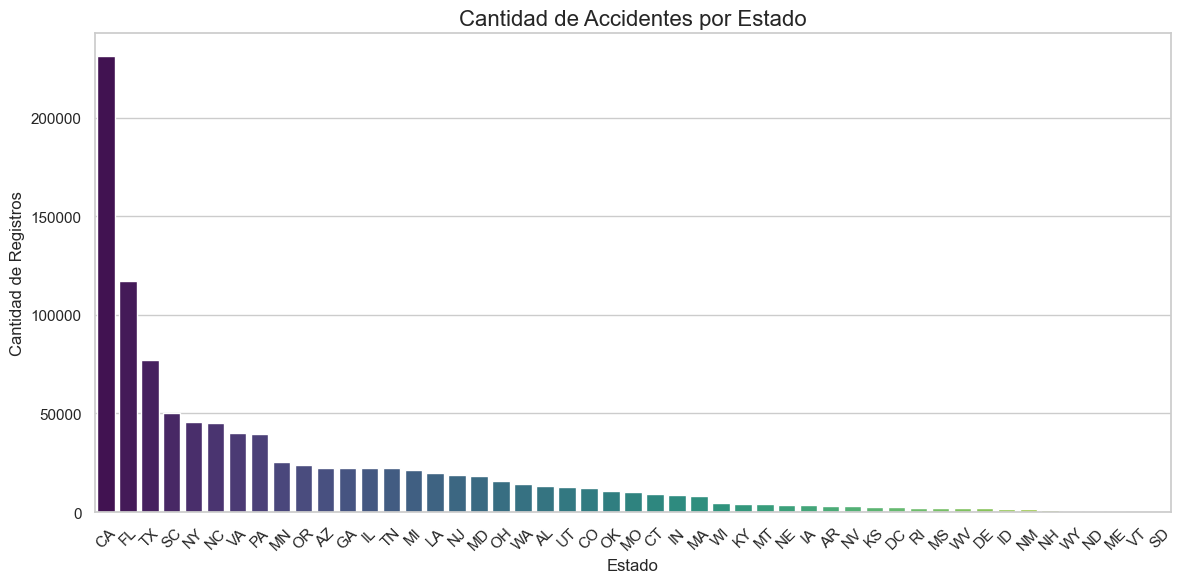

In [6]:
try:
    with ElasticSearchProvider(index="us-accidents_march23") as es:

        response = es.search(
            query = {
                "size": 0,  # No queremos los documentos, solo la agregación
                "aggs": {
                    "states_count": {
                        "terms": {
                            "field": "State",
                            "size": 50
                        }
                    }
                }
            }
        )
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        states = [bucket['key'] for bucket in response['aggregations']['states_count']['buckets']]
        counts = [bucket['doc_count'] for bucket in response['aggregations']['states_count']['buckets']]
        
        # Configurar estilo de Seaborn
        sns.set(style="whitegrid")

        # Crear figura
        plt.figure(figsize=(12, 6))
        sns.barplot(x=states, y=counts, palette="viridis")

        # Añadir etiquetas y título
        plt.title("Cantidad de Accidentes por Estado", fontsize=16)
        plt.xlabel("Estado")
        plt.ylabel("Cantidad de Registros")
        plt.xticks(rotation=45)

        # Mostrar la gráfica
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"an error occurred: {e}")

### Mapa de calor de accidentes

C:\Users\sebas\AppData\Local\Temp\ipykernel_34228\2302113709.py:13: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: Do

Map image saved as 'mapa_accidentes_usa.png'


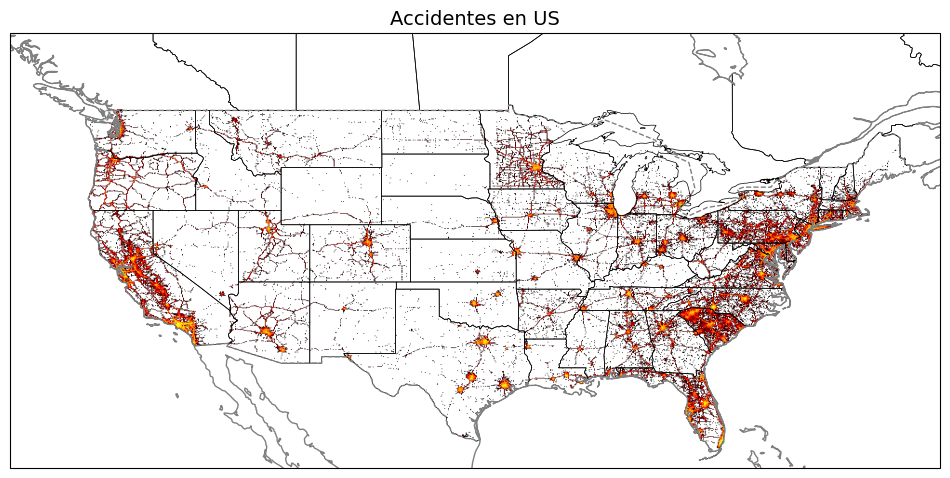

In [4]:
from elasticsearch import Elasticsearch

try:

    with Elasticsearch("http://localhost:9200") as es:

        index_name = "us-accidents_march23"  # Nombre del índice de ElasticSearch

        # Scroll para traer muchos documentos 
        scroll_size = 5000
        all_coords = []

        response = es.search(
            index=index_name,
            scroll='2m',
            size=scroll_size,
            _source=["Start_Lat", "Start_Lng"],
            body={
                "query": {
                    "bool": {
                        "must": [
                            { "exists": { "field": "Start_Lat" } },
                            { "exists": { "field": "Start_Lng" } }
                        ]
                    }
                }
            }
        )

        scroll_id = response['_scroll_id']
        hits = response['hits']['hits']

        while hits and len(all_coords) < 900_000:
            for hit in hits:
                src = hit['_source']
                lat = src.get('Start_Lat')
                lng = src.get('Start_Lng')
                if lat is not None and lng is not None:
                    all_coords.append((lng, lat))   # (x, y) = (long, lat)

            response = es.scroll(scroll_id=scroll_id, scroll='2m')
            scroll_id = response['_scroll_id']
            hits = response['hits']['hits']

        es.clear_scroll(scroll_id=scroll_id)

        # Convertir a DataFrame
        df = pd.DataFrame(all_coords, columns=['x', 'y'])

        # Crear un canvas (área de dibujo)
        canvas = ds.Canvas(plot_width=1000, plot_height=600, x_range=[-130, -65], y_range=[24, 50])  # USA bounds
        agg = canvas.points(df, 'x', 'y')

        # Convertir agregación en imagen
        img = tf.shade(agg, cmap=Hot, how='log')

        # Convertir a imagen PIL
        img_pil = img.to_pil()

        # Dibujar sobre Cartopy
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-130, -65, 24, 50])  # USA mainland

        # Mostrar la imagen de datashader como fondo
        ax.imshow(img_pil, extent=[-130, -65, 24, 50], origin='upper')

        # Añadir contorno de estados
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', linestyle='--')
        ax.add_feature(cfeature.COASTLINE, edgecolor='gray')

        # Mostrar imagen
        # img.to_pil().show()

        # export_image(img, filename="accidents_map")

        ax.set_title("Accidentes en US", fontsize=14)
        plt.savefig("mapa_accidentes_usa.png", dpi=300, bbox_inches='tight')
        print("Map image saved as 'mapa_accidentes_usa.png'")
        # plt.savefig("mapa_accidentes_usa.pdf")
        # plt.savefig("mapa_accidentes_usa.svg")

        
except Exception as e:
    print(f"an error occurred: {e}")

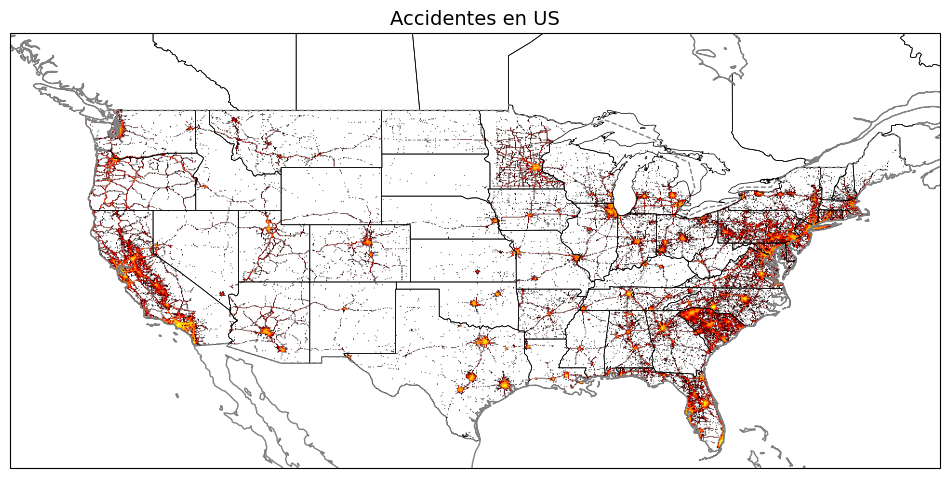

Este es un mapa de calor que nos muestra donde es que se concentran los accidentes en US